In [15]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import gseapy as gp
from torch_geometric.nn import GATv2Conv
from performer_pytorch import Performer

device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

In [13]:

# ============================================================
# 1️⃣ ROTARY EXPRESSION EMBEDDING
# ============================================================
class PositionalExprEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.mask_token_id = -10  # same as BulkFormer
        self.inv_freq = nn.Parameter(
            1.0 / (100 ** (torch.arange(0, dim, 2).float() / dim)),
            requires_grad=False
        )

    def forward(self, x):
        # x : [batch, genes]
        mask_idx = (x == self.mask_token_id).nonzero()

        rot = torch.einsum("bi,j->bij", x, self.inv_freq)
        rot = torch.cat((rot.sin(), rot.cos()), dim=-1)

        # zero out masked tokens
        if len(mask_idx) > 0:
            rot[mask_idx[:, 0], mask_idx[:, 1]] = 0

        return rot

# ============================================================
# 2️⃣ GBFormer (GAT + Performer blocks)
# ============================================================
class GBFormer(nn.Module):
    def __init__(self, dim, gene_length,
                 bin_head=2, full_head=2, bins=6, p_repeat=1):
        super().__init__()

        self.dim = dim
        self.bins = bins
        self.gene_length = gene_length

        # GAT module
        self.g = GATv2Conv(dim, dim, add_self_loops=False)

        # bin selector
        self.which_b = nn.Linear(dim, 1)

        # small Performer heads
        self.b = nn.ModuleList([
            Performer(
                dim=dim,
                heads=bin_head,
                dim_head=32,
                depth=1,
                attn_dropout=0.1,
                reversible=False
            )
            for _ in range(bins)
        ])

        self.f = nn.ModuleList([
            Performer(
                dim=dim,
                heads=full_head,
                dim_head=32,
                depth=1,
                attn_dropout=0.1,
                reversible=False
            )
            for _ in range(p_repeat)
        ])

        self.ln = nn.LayerNorm(dim)

    def forward(self, x, edge_index):
        # x: [B, G, E]
        B, G, E = x.shape

        x = self.ln(x)

        # --- SAFE GRAPH UPDATE (no in-place) ---
        x_graph = []
        for b in range(B):
            gx = self.g(x[b], edge_index)
            x_graph.append(x[b] + gx)
        x = torch.stack(x_graph, dim=0)

        # --- choose bins ---
        scores = self.which_b(x).squeeze(-1)      # [B, G]
        order = torch.argsort(scores, dim=1, descending=True)  # [B, G]
        order_exp = order.unsqueeze(-1).expand(-1, -1, E)

        # reorder (no in-place)
        x_sorted = torch.gather(x, 1, order_exp)

        # split
        n = (G - 1) // self.bins + 1
        chunks = torch.split(x_sorted, n, dim=1)

        # run performer per chunk
        outs = []
        for chunk, layer in zip(chunks, self.b):
            outs.append(layer(chunk))
        xs = torch.cat(outs, dim=1)

        # --- UNSORT (no inplace scatter_) ---
        out = torch.zeros_like(xs)
        out = out.scatter(1, order_exp, xs)   # **THIS IS NOT INPLACE**

        # --- global Performer ---
        for layer in self.f:
            out = layer(out)

        return out




# ============================================================
# 3️⃣ BULKFORMER MODEL (Modified)
# ============================================================
class BulkFormer(nn.Module):
    def __init__(self, dim, graph, gene_emb, gene_length,
                 bin_head=2, full_head=2, bins=10, gb_repeat=2, p_repeat=1):
        super().__init__()

        self.dim = dim
        self.graph = graph
        self.gene_length = gene_length

        # 320-dim ESM2 embedding
        self.gene_emb = nn.Parameter(gene_emb)

        self.gene_emb_proj = nn.Sequential(
            nn.Linear(gene_emb.shape[1], 4 * dim),
            nn.ReLU(),
            nn.Linear(4 * dim, dim)
        )

        self.expr_emb = PositionalExprEmbedding(dim)

        # AE latent → sample context vector
        self.ae_enc = nn.Sequential(
            nn.Linear(gene_length, 4 * dim),
            nn.ReLU(),
            nn.Linear(4 * dim, dim)
        )

        self.x_proj = nn.Sequential(
            nn.Linear(dim, 4 * dim),
            nn.ReLU(),
            nn.Linear(4 * dim, dim)
        )

        self.blocks = nn.ModuleList([
            GBFormer(dim, gene_length,
                     bin_head=bin_head,
                     full_head=full_head,
                     bins=bins,
                     p_repeat=p_repeat)
            for _ in range(gb_repeat)
        ])

        self.ln = nn.LayerNorm(dim)

        # Final head predicts expression
        self.head = nn.Sequential(
            nn.Linear(dim, 4 * dim),
            nn.ReLU(),
            nn.Linear(4 * dim, 1)
        )

    def forward(self, x, ae_latent=None):
        # x: [B, G]
        B, G = x.shape

        gene_tok = self.gene_emb_proj(self.gene_emb).unsqueeze(0)  # [1, G, dim]
        expr_tok = self.expr_emb(x)                                # [B, G, dim]
        ae_tok = ae_latent.unsqueeze(1)                            # [B, 1, dim]

        x = expr_tok + gene_tok + ae_tok
        x = self.x_proj(x)

        for block in self.blocks:
            x = block(x, self.graph)

        x = self.ln(x)

        out = self.head(x).squeeze(-1)  # predict masked expression
        return out



In [10]:
# Load expression validation set
val_expr = pd.read_parquet(
    "./data/archs4/processed_short_proteins/val_expr_logtpm_short.parquet"
)

X_val = torch.tensor(val_expr.T.values.astype("float32"), device=device)
N_val, G = X_val.shape

print("Validation expression:", X_val.shape)

# Load ESM2 gene identity embeddings
esm2_raw = torch.load("./data/embeddings/esm2_t6_8M_UR50D_gene_embeddings.pt")
esm2 = esm2_raw["embeddings"].float().to(device)
print("ESM2:", esm2.shape)

# # Load AE sample latent embeddings (if needed)
# ae_val = torch.load("./data/embeddings/ae_gene_latents_320_val_set.pt")
# ae_val = torch.tensor(ae_val, dtype=torch.float32).to(device)
# print("AE latent:", ae_val.shape)


Validation expression: torch.Size([9557, 19357])
ESM2: torch.Size([19357, 320])


In [17]:
model = BulkFormer(
    dim=320,
    graph=torch.load("./graph/edge_index_top20.pt").long().to(device),
    gene_emb=esm2,          # <-- MUST MATCH the same tensor shape
    gene_length=G,
    gb_repeat=1,
    bins=1,
    bin_head=2,
    full_head=2,
    p_repeat=1
).to(device)

# Load weights
state = torch.load("bulkformer_gbformer.pt", map_location=device)
model.load_state_dict(state)
model.eval()


BulkFormer(
  (gene_emb_proj): Sequential(
    (0): Linear(in_features=320, out_features=1280, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1280, out_features=320, bias=True)
  )
  (expr_emb): PositionalExprEmbedding()
  (ae_enc): Sequential(
    (0): Linear(in_features=19357, out_features=1280, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1280, out_features=320, bias=True)
  )
  (x_proj): Sequential(
    (0): Linear(in_features=320, out_features=1280, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1280, out_features=320, bias=True)
  )
  (blocks): ModuleList(
    (0): GBFormer(
      (g): GATv2Conv(320, 320, heads=1)
      (which_b): Linear(in_features=320, out_features=1, bias=True)
      (b): ModuleList(
        (0): Performer(
          (net): SequentialSequence(
            (layers): ModuleList(
              (0): ModuleList(
                (0): PreLayerNorm(
                  (norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              

In [18]:
with torch.no_grad():
    # gene identity embedding only
    gene_embed = model.gene_emb_proj(model.gene_emb)  # shape (19357, 320)

gene_embed = gene_embed.cpu().numpy()
gene_embed.shape


(19357, 320)

In [19]:
tsne = TSNE(
    n_components=2,
    learning_rate="auto",
    init="random",
    perplexity=30,
    random_state=42
)

tsne_emb = tsne.fit_transform(gene_embed)
tsne_emb.shape


(19357, 2)

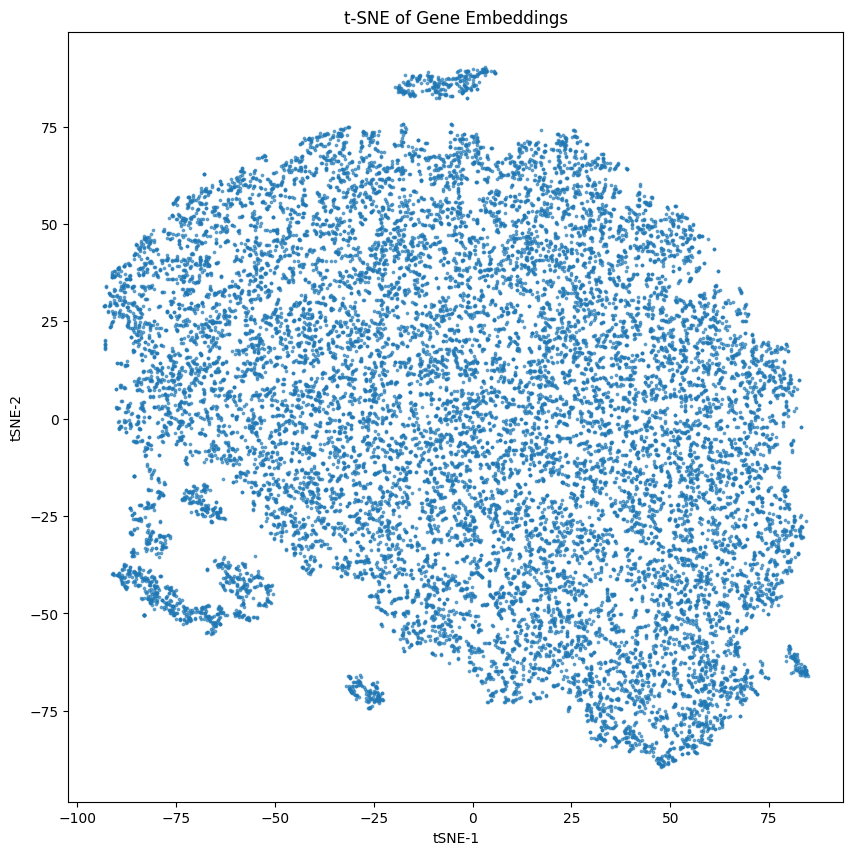

In [20]:
plt.figure(figsize=(10,10))
plt.scatter(tsne_emb[:,0], tsne_emb[:,1], s=3, alpha=0.6)
plt.title("t-SNE of Gene Embeddings")
plt.xlabel("tSNE-1")
plt.ylabel("tSNE-2")
plt.show()


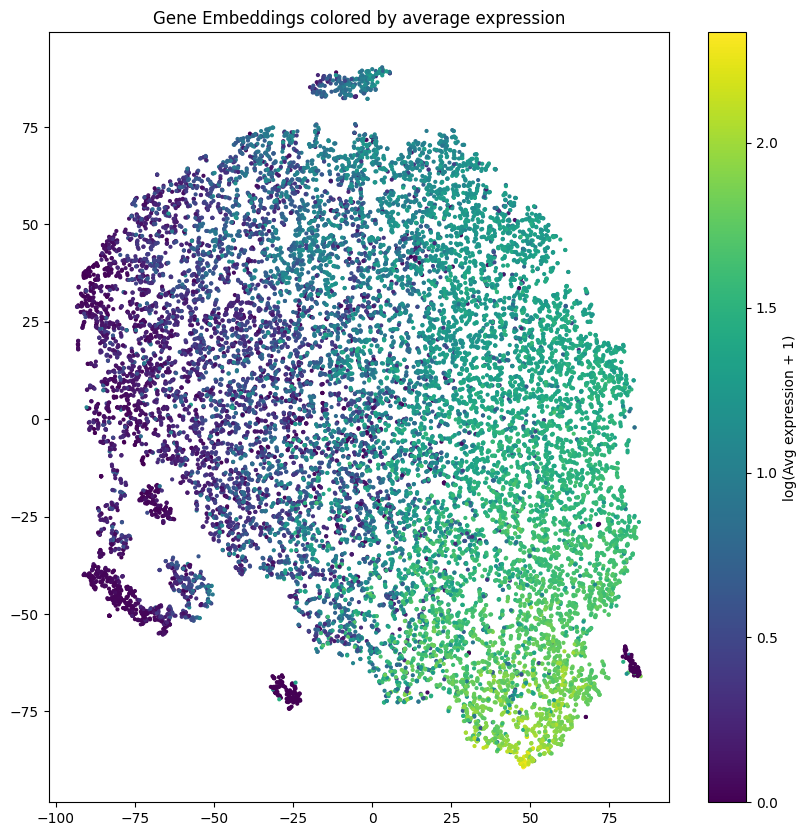

In [21]:
avg_expr = X_val.mean(dim=0).cpu().numpy()  # mean over samples → vector of length 19357

plt.figure(figsize=(10,10))
plt.scatter(
    tsne_emb[:,0], tsne_emb[:,1],
    c=np.log1p(avg_expr),
    cmap="viridis",
    s=4
)
plt.colorbar(label="log(Avg expression + 1)")
plt.title("Gene Embeddings colored by average expression")
plt.show()


In [22]:
k = 10  # number of clusters
km = KMeans(n_clusters=k, random_state=42)
clusters = km.fit_predict(gene_embed)

clusters[:20]


array([3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 4, 4, 3, 6, 0, 1, 4, 1, 0, 6],
      dtype=int32)

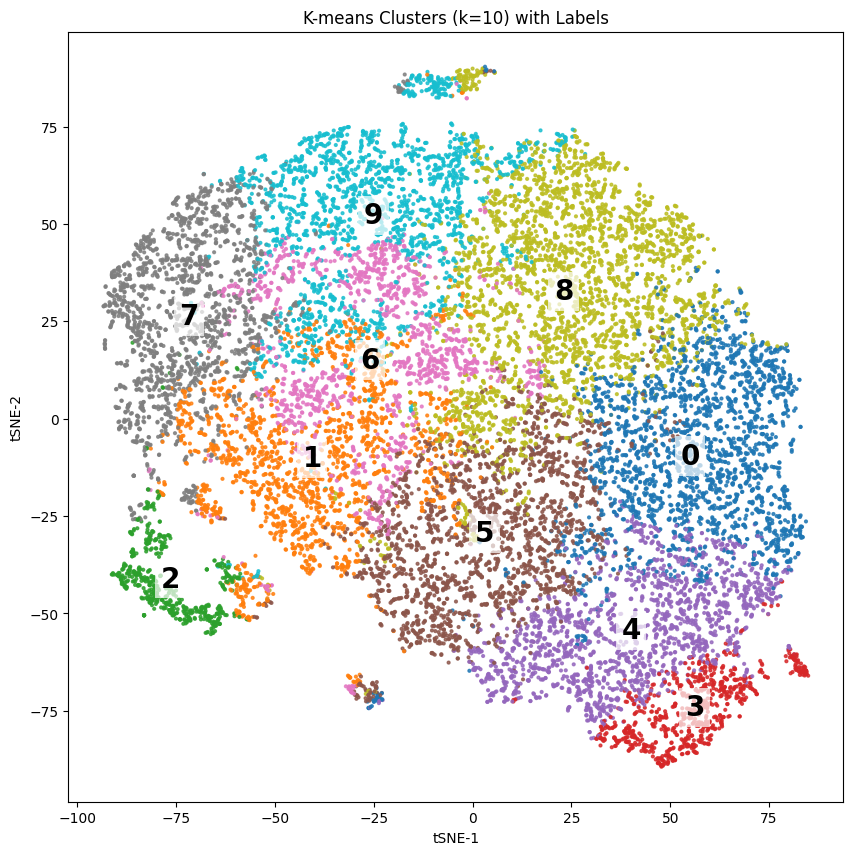

In [33]:
plt.figure(figsize=(10,10))

# Scatter points
plt.scatter(
    tsne_emb[:,0], tsne_emb[:,1],
    c=clusters,
    cmap="tab10",
    s=4,
    alpha=0.8
)

# Add cluster labels at the cluster centroid
for c in range(k):
    cx = tsne_emb[clusters == c, 0].mean()
    cy = tsne_emb[clusters == c, 1].mean()
    plt.text(
        cx, cy, str(c),
        fontsize=20, fontweight="bold",
        color="black",
        ha="center", va="center",
        bbox=dict(facecolor="white", alpha=0.7, edgecolor='none')
    )

plt.title("K-means Clusters (k=10) with Labels")
plt.xlabel("tSNE-1")
plt.ylabel("tSNE-2")
plt.show()


In [27]:
# load the gene order file from training if you have one
gene_order = pd.read_csv("./data/archs4/processed_short_proteins/test_gene_order_short.csv")

print("Columns:", gene_order.columns.tolist())
print(gene_order.head(10))

gene_names = gene_order["gene_symbol"].tolist()

len(gene_names)


Columns: ['gene_symbol']
  gene_symbol
0      MT-ND1
1      MT-ND2
2      MT-CO1
3      MT-CO2
4     MT-ATP8
5     MT-ATP6
6      MT-CO3
7      MT-ND3
8     MT-ND4L
9      MT-ND4


19357

In [28]:
enrichment_results = {}

for c in range(k):
    gene_list = [gene_names[i] for i in range(len(gene_names)) if clusters[i] == c]

    enr = gp.enrichr(
        gene_list=gene_list,
        gene_sets=["GO_Biological_Process_2021"],
        organism="Human",
        cutoff=0.05
    )
    
    enrichment_results[c] = enr.results
    print(f"Cluster {c}: {len(enr.results)} significant GO terms")


Cluster 0: 4741 significant GO terms
Cluster 1: 4026 significant GO terms
Cluster 2: 651 significant GO terms
Cluster 3: 3377 significant GO terms
Cluster 4: 4637 significant GO terms
Cluster 5: 4798 significant GO terms
Cluster 6: 3621 significant GO terms
Cluster 7: 3408 significant GO terms
Cluster 8: 5051 significant GO terms
Cluster 9: 4179 significant GO terms


In [29]:
kegg_results = {}

for c in range(k):
    gene_list = [gene_names[i] for i in range(len(gene_names)) if clusters[i] == c]

    enr = gp.enrichr(
        gene_list=gene_list,
        gene_sets=["KEGG_2021_Human"],
        organism="Human",
        cutoff=0.05
    )
    
    kegg_results[c] = enr.results
    print(f"Cluster {c}: {len(enr.results)} KEGG pathways")


Cluster 0: 309 KEGG pathways
Cluster 1: 293 KEGG pathways
Cluster 2: 63 KEGG pathways
Cluster 3: 282 KEGG pathways
Cluster 4: 311 KEGG pathways
Cluster 5: 309 KEGG pathways
Cluster 6: 263 KEGG pathways
Cluster 7: 282 KEGG pathways
Cluster 8: 318 KEGG pathways
Cluster 9: 308 KEGG pathways


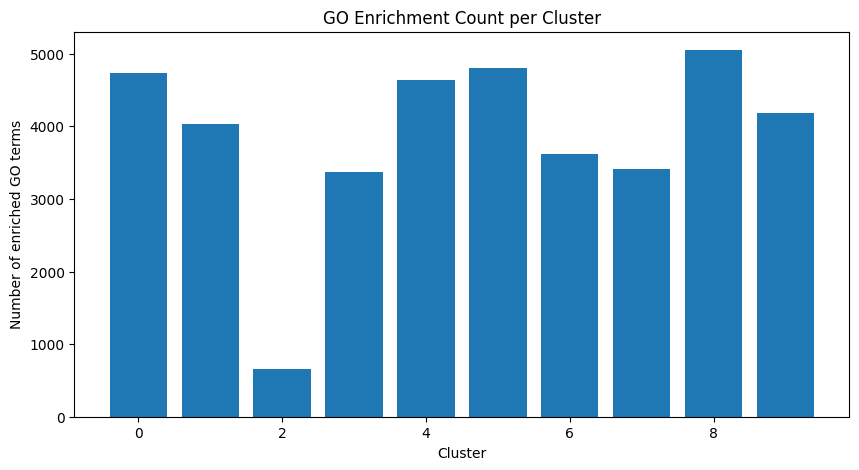

In [30]:
go_counts = [len(enrichment_results[c]) for c in range(k)]

plt.figure(figsize=(10,5))
plt.bar(range(k), go_counts)
plt.xlabel("Cluster")
plt.ylabel("Number of enriched GO terms")
plt.title("GO Enrichment Count per Cluster")
plt.show()


In [31]:
def compute_rich_factor(df):
    rf = []
    for s in df["Overlap"]:
        a, b = s.split("/")
        rf.append(int(a) / int(b))
    return np.array(rf)


In [37]:
cell_cycle_terms = [
    "cell cycle",
    "mitotic",
    "chromosome",
    "DNA replication",
    "splicing",
    "RNA splicing",
    "DNA repair",
    "cell division",
    "chromatin organization"
]


immune_terms = [
    "immune",
    "defense",
    "antigen",
    "interferon",
    "T cell",
    "B cell",
    "inflammatory",
    "cytokine",
    "pathogen",
    "response to bacterium",
]

import re

def count_matches(df, keywords):
    if df is None or len(df) == 0:
        return 0
    pattern = "|".join([re.escape(k) for k in keywords])
    return df["Term"].str.contains(pattern, case=False, regex=True).sum()

cluster_theme_scores = {}

for c in range(k):
    df = enrichment_results[c]
    
    score_cellcycle = count_matches(df, cell_cycle_terms)
    score_immune    = count_matches(df, immune_terms)
    
    cluster_theme_scores[c] = {
        "cell_cycle_score": score_cellcycle,
        "immune_score": score_immune,
        "n_terms": len(df)
    }

cluster_theme_scores



{0: {'cell_cycle_score': np.int64(162),
  'immune_score': np.int64(246),
  'n_terms': 4741},
 1: {'cell_cycle_score': np.int64(58),
  'immune_score': np.int64(293),
  'n_terms': 4026},
 2: {'cell_cycle_score': np.int64(12),
  'immune_score': np.int64(56),
  'n_terms': 651},
 3: {'cell_cycle_score': np.int64(107),
  'immune_score': np.int64(204),
  'n_terms': 3377},
 4: {'cell_cycle_score': np.int64(147),
  'immune_score': np.int64(271),
  'n_terms': 4637},
 5: {'cell_cycle_score': np.int64(109),
  'immune_score': np.int64(312),
  'n_terms': 4798},
 6: {'cell_cycle_score': np.int64(79),
  'immune_score': np.int64(244),
  'n_terms': 3621},
 7: {'cell_cycle_score': np.int64(79),
  'immune_score': np.int64(223),
  'n_terms': 3408},
 8: {'cell_cycle_score': np.int64(161),
  'immune_score': np.int64(268),
  'n_terms': 5051},
 9: {'cell_cycle_score': np.int64(145),
  'immune_score': np.int64(226),
  'n_terms': 4179}}

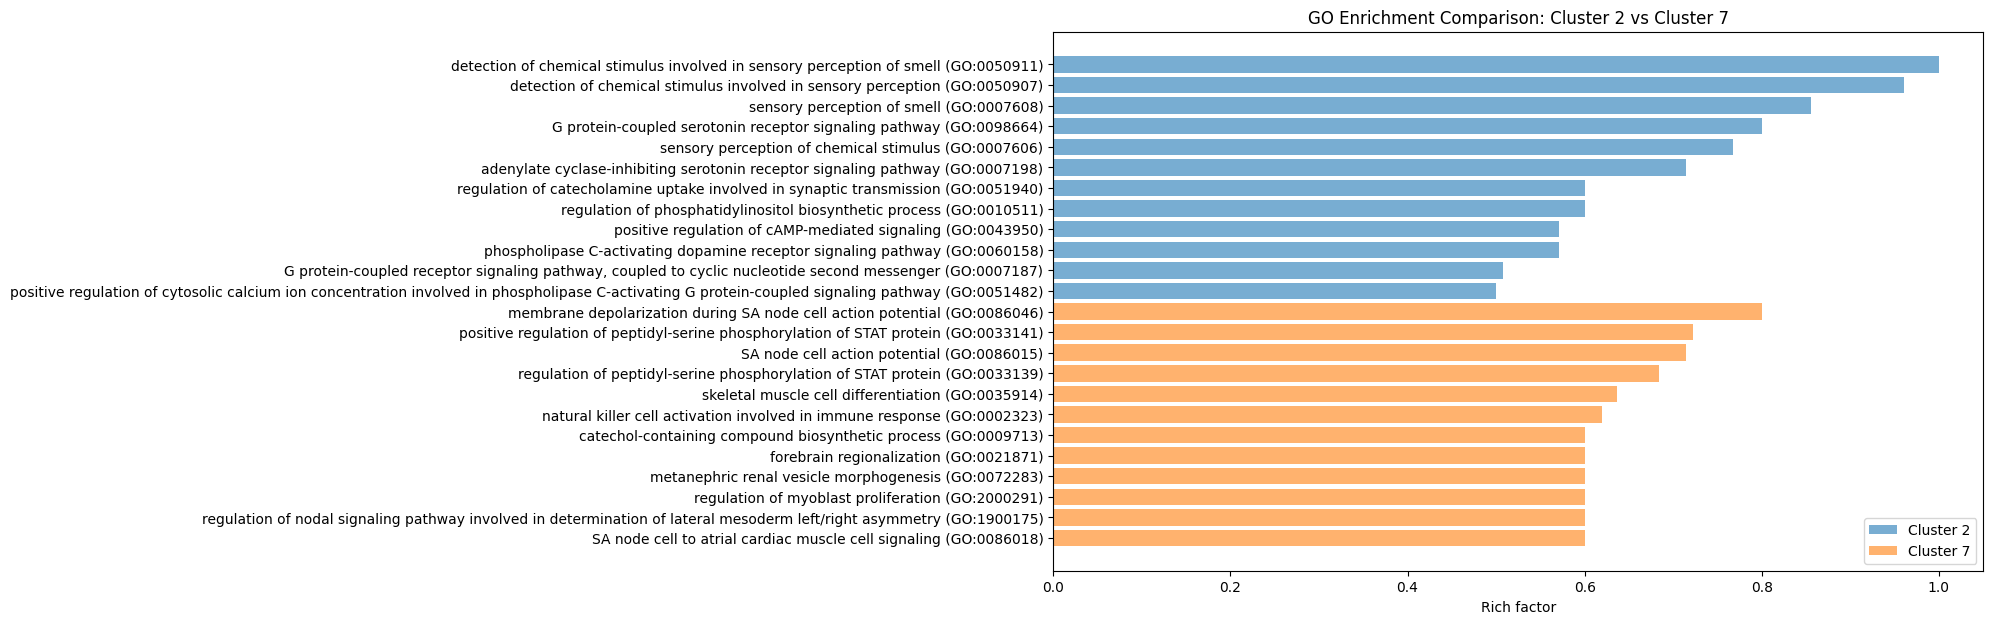

In [48]:
c1, c2 = 2, 7

df1 = enrichment_results[c1].copy()
df2 = enrichment_results[c2].copy()

df1["rich_factor"] = compute_rich_factor(df1)
df2["rich_factor"] = compute_rich_factor(df2)

# Top 12 for clean plot
df1_top = df1.nlargest(12, "rich_factor")
df2_top = df2.nlargest(12, "rich_factor")

plt.figure(figsize=(12,7))
plt.barh(df1_top["Term"], df1_top["rich_factor"], alpha=0.6, label=f"Cluster {c1}")
plt.barh(df2_top["Term"], df2_top["rich_factor"], alpha=0.6, label=f"Cluster {c2}")
plt.xlabel("Rich factor")
plt.title(f"GO Enrichment Comparison: Cluster {c1} vs Cluster {c2}")
plt.legend()
plt.gca().invert_yaxis()
plt.show()


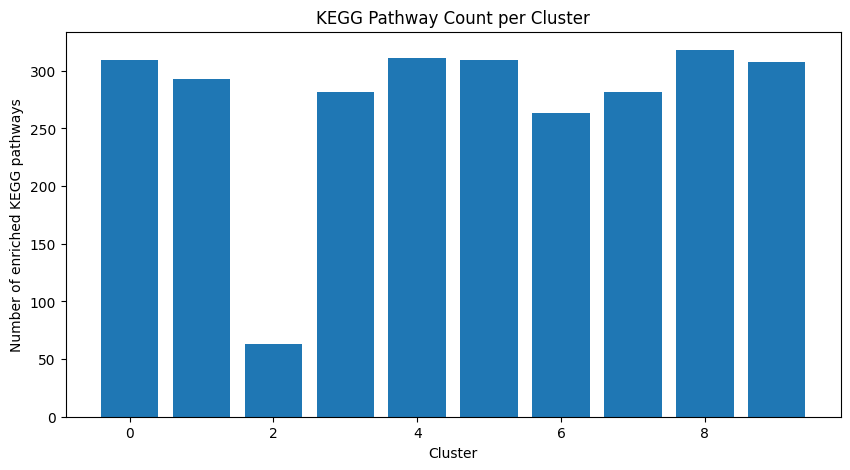

In [38]:
kegg_counts = [len(kegg_results[c]) for c in range(k)]

plt.figure(figsize=(10,5))
plt.bar(range(k), kegg_counts)
plt.xlabel("Cluster")
plt.ylabel("Number of enriched KEGG pathways")
plt.title("KEGG Pathway Count per Cluster")
plt.show()


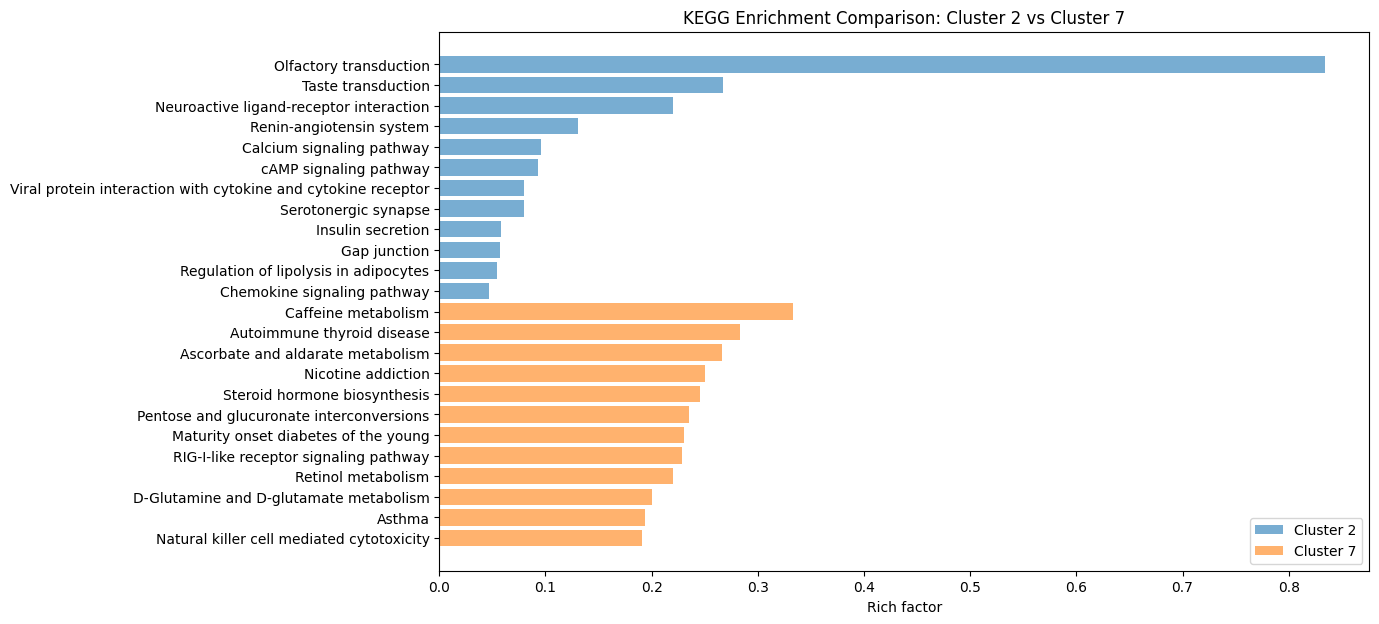

In [47]:
def compute_kegg_rich_factor(df):
    rf = []
    for s in df["Overlap"]:
        a, b = s.split("/")
        rf.append(int(a) / int(b))
    return np.array(rf)


c1, c2 = 2, 7

df1 = kegg_results[c1].copy()
df2 = kegg_results[c2].copy()

df1["rich_factor"] = compute_kegg_rich_factor(df1)
df2["rich_factor"] = compute_kegg_rich_factor(df2)

df1_top = df1.nlargest(12, "rich_factor")
df2_top = df2.nlargest(12, "rich_factor")

plt.figure(figsize=(12,7))
plt.barh(df1_top["Term"], df1_top["rich_factor"], alpha=0.6, label=f"Cluster {c1}")
plt.barh(df2_top["Term"], df2_top["rich_factor"], alpha=0.6, label=f"Cluster {c2}")
plt.xlabel("Rich factor")
plt.title(f"KEGG Enrichment Comparison: Cluster {c1} vs Cluster {c2}")
plt.legend()
plt.gca().invert_yaxis()
plt.show()


In [40]:
# Canonical squamous epithelial program markers
squamous_markers = [
    "KRT5","KRT6A","KRT6B","KRT6C","KRT14","KRT16","KRT17","KRT19",
    "DSC1","DSC2","DSG1","DSG2","DSG3",
    "JUP","PKP1","PKP3",
    "IVL","SPRR1A","SPRR1B","SPRR2A","SPRR2B",
    "LCE1A","LCE1B","LCE1C","LCE2A","LCE2B",
    "TP63","SOX2","GRHL3","ELF3"
]

# Keep only genes that exist in your expression dataset
squamous_present = [g for g in squamous_markers if g in gene_names]
print("Squamous markers present:", squamous_present)

squamous_gene_mask = np.array([1 if g in squamous_present else 0 for g in gene_names])


Squamous markers present: ['KRT5', 'KRT6A', 'KRT6B', 'KRT6C', 'KRT14', 'KRT16', 'KRT17', 'KRT19', 'DSC1', 'DSC2', 'DSG1', 'DSG2', 'DSG3', 'JUP', 'PKP1', 'PKP3', 'IVL', 'SPRR1A', 'SPRR1B', 'SPRR2A', 'SPRR2B', 'LCE1A', 'LCE1B', 'LCE1C', 'LCE2A', 'LCE2B', 'TP63', 'SOX2', 'GRHL3', 'ELF3']


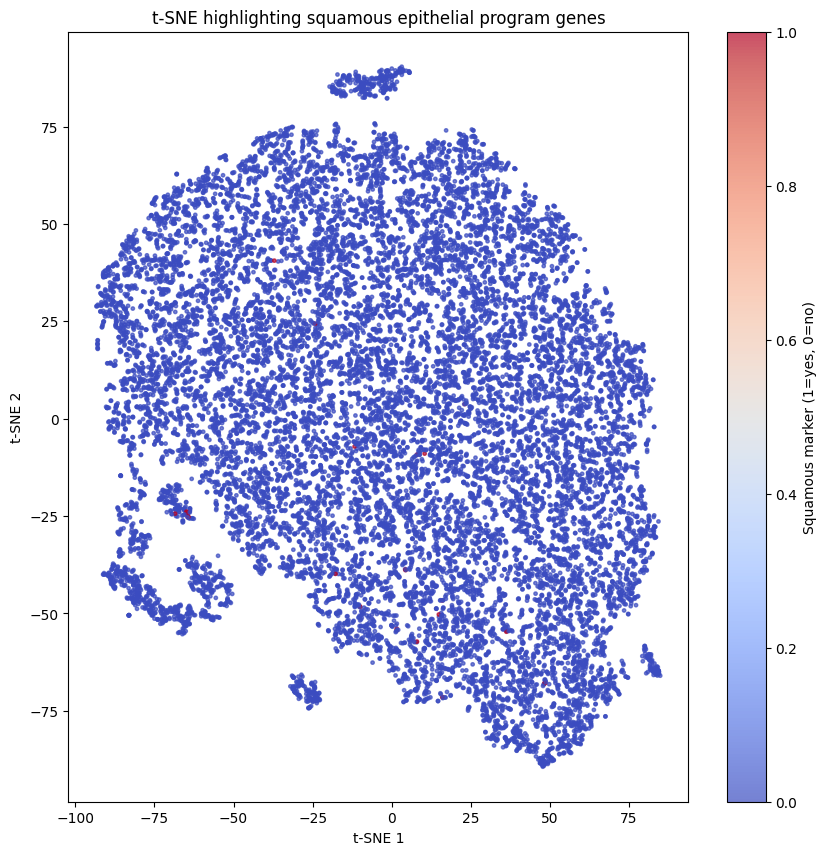

In [41]:
plt.figure(figsize=(10,10))
plt.scatter(
    tsne_emb[:,0],
    tsne_emb[:,1],
    c=squamous_gene_mask,
    cmap="coolwarm",
    s=6,
    alpha=0.7
)
plt.colorbar(label="Squamous marker (1=yes, 0=no)")
plt.title("t-SNE highlighting squamous epithelial program genes")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()


/tmp/ipykernel_66668/226083126.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_sq, x="cluster", y="squamous_markers", palette="viridis")


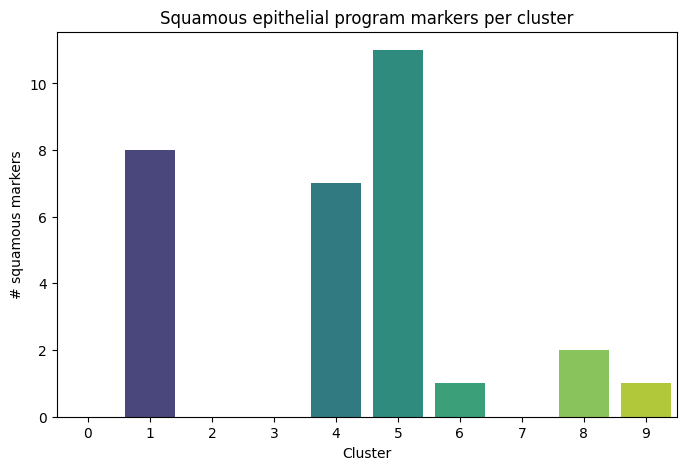

In [42]:
import pandas as pd
import seaborn as sns

cluster_squamous_counts = []

for c in range(k):
    cluster_indices = np.where(clusters == c)[0]
    genes_in_cluster = [gene_names[i] for i in cluster_indices]
    count = sum(1 for g in squamous_present if g in genes_in_cluster)
    cluster_squamous_counts.append(count)

df_sq = pd.DataFrame({
    "cluster": list(range(k)),
    "squamous_markers": cluster_squamous_counts
})

plt.figure(figsize=(8,5))
sns.barplot(data=df_sq, x="cluster", y="squamous_markers", palette="viridis")
plt.title("Squamous epithelial program markers per cluster")
plt.xlabel("Cluster")
plt.ylabel("# squamous markers")
plt.show()
